# Часть 1. Vanilla Autoencoder 

## 1.1. Подготовка данных 


In [67]:
import numpy as np
import pandas as pd
import skimage
from skimage import io
from torch.autograd import Variable
from torchvision import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import torch.nn as nn
import os
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision.transforms import ToTensor, Lambda
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline
from sklearn.manifold import TSNE
import plotly.express as px

In [68]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img:resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:


data, attrs = fetch_dataset()

images not found, donwloading...


--2022-12-18 00:55:56--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  535K 3m18s
    50K .......... .......... .......... .......... ..........  0% 1.04M 2m29s
   100K .......... .......... .......... .......... ..........  0% 25.0M 1m40s
   150K .......... .......... .......... .......... ..........  0% 62.5M 76s
   200K .......... .......... .......... .......... ..........  0% 1.09M 79s
   250K .......... .......... .......... .......... ..........  0% 47.8M 67s
   300K .......... .......... .......... .......... ..........  0% 57.3M 57s
   350K .......... .......... .......... .......... ..........  0% 45.4M 50s
   400K .......... ...

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2022-12-18 00:56:02--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2022-12-18 00:56:03--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  858K 17s
    50K .......... .......... .......... .......... ..........  0% 1.67M 13s
   100K .......... .......... .......... .......... ..........  1% 87.0M 8s
   150K .......... .......... .......... 

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [15]:
train,val, attrs_train,attrs_val = train_test_split(data,attrs, train_size=0.75)

In [17]:
train = torch.Tensor(train)
val = torch.Tensor(val)

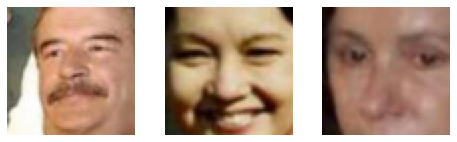

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(1,4):
  plt.subplot(3,3, i)
  random_img = int(np.random.uniform(1,13143))
  plt.imshow(data[random_img])
  plt.axis('off')
plt.show()

In [19]:
X_train_t =  torch.permute(torch.tensor(train, dtype=torch.float32), (0, 3, 1, 2)) 
X_val_t =  torch.permute(torch.tensor(val, dtype=torch.float32), (0, 3, 1, 2))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [21]:
from torch.utils.data import DataLoader
batch_size = 10
data_train = torch.utils.data.DataLoader(X_train_t, batch_size=25)
data_val = torch.utils.data.DataLoader(X_val_t, batch_size=25) 
   

## 1.2. Архитектура модели (1.5 балла)


In [22]:
dim_code = 64 # выберу размер латентного вектора

Реализую autoencoder

In [24]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      
      self.encoder = nn.Sequential(
          nn.Conv2d(3,32, kernel_size=3,padding =1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          

          nn.Conv2d(32,32, kernel_size=7,stride=1, padding = 3),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.Conv2d(32,64, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(262144, 200)
      )
      self.decoder = nn.Sequential(
          nn.Linear(200, 262144),
          nn.Unflatten(1, (64, 64, 64)),
          nn.ConvTranspose2d(64,32, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.LeakyReLU(0.01),

          nn.ConvTranspose2d(32,16, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.LeakyReLU(0.01),

          nn.ConvTranspose2d(16,3, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(3),
          nn.Sigmoid()
         
      )
       
        
    def forward(self, x):
        x = x.float()
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        
        return  reconstructed, latent

## 1.3 Обучение 

In [25]:
next(iter(data_train)).shape

torch.Size([25, 3, 64, 64])

In [10]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
X_val=next(iter(data_val))
criterion = nn.BCELoss()
train_loss=[]
val_loss=[]
exp=[]
n_epochs =10
autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

for epoch in tqdm_notebook(range(n_epochs)):
  autoencoder.train()
  train_losses_per_epoch = []
  for i, X_batch in enumerate(data_train):
    optimizer.zero_grad()
    reconstructed, latent = autoencoder(X_batch.to(device))
    loss = criterion(reconstructed, X_batch.to(device))
    loss.backward()
    optimizer.step()
    train_losses_per_epoch.append(loss.item())
  train_loss.append(np.mean(train_losses_per_epoch))

  autoencoder.eval()
  val_losses_per_epoch=[]
  with torch.no_grad():
    for X_batch in data_val:
      reconstructed, latent = autoencoder(X_batch.to(device))
      loss = criterion(reconstructed,X_batch.to(device))
      val_losses_per_epoch.append(loss.item())
  val_loss.append(np.mean(val_losses_per_epoch))

  with torch.no_grad():
    Y_hat, latent = autoencoder(X_val.to(device))
    Y_hat= Y_hat.cpu()
  clear_output(wait=True)
  fig, axs = plt.subplots(2, 6, figsize=(12,12))
  for k in range(6):
      plt.title('Real')
      axs[0][k].imshow(val[k])
      
      plt.axis('off')
      plt.subplot(2, 6, k+7)
      plt.title('Output')
      axs[1][k].imshow(np.rollaxis(Y_hat[k].detach().cpu().numpy(), 0, 3), cmap='gray')
      
      plt.axis('off')
      plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(val_losses_per_epoch)))
  plt.show()




NameError: name 'data_val' is not defined

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

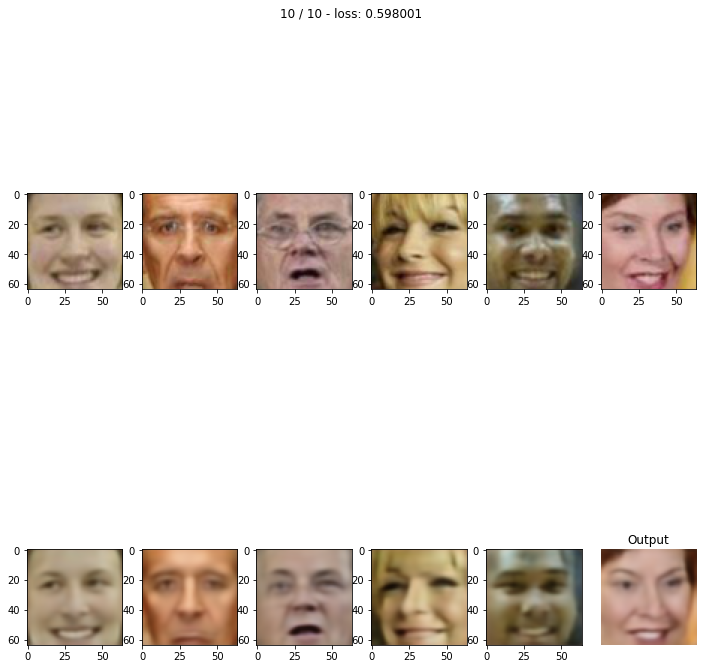

In [29]:
with torch.no_grad():
    Y_hat, latent = autoencoder(X_val.to(device))
    Y_hat= Y_hat.cpu()
fig, axs = plt.subplots(2, 6, figsize=(12,12))
for k in range(7,13):
    axs[0][k-7].imshow(val[k])
    plt.title('Real')
    plt.axis('off')

    axs[1][k-7].imshow(np.rollaxis(Y_hat[k].detach().cpu().numpy(), 0, 3), cmap='gray')
    plt.title('Output')
    plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(val_losses_per_epoch)))
plt.show()
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

## 1.4. Sampling 

Попробую создать что-то НОВОЕ

Предоставлю декодеру  сгенерированные векторы (например, из нормального распределения) и посмотрю на результат реконструкции декодера

In [30]:
latent.shape

torch.Size([25, 200])

In [31]:
mean = latent.mean()
std = latent.std()

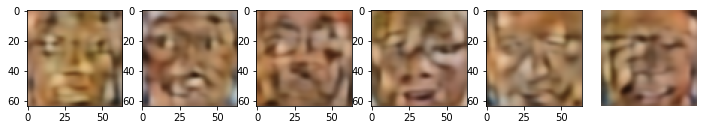

In [32]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 200)).to(device)*std+mean
output = autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decoder(z)
  

fig, axs = plt.subplots(1, 6, figsize=(12,12))
for k in range(6):
    axs[k].imshow(np.rollaxis(output[k].detach().cpu().numpy(), 0, 3), cmap='gray')
    plt.axis('off')

plt.show()

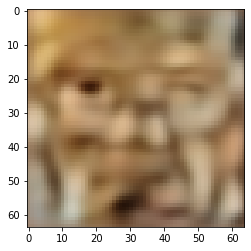

In [33]:
plt.imshow(np.rollaxis(output[10].detach().cpu().numpy(),0,3))

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План :

1. Выделю "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.


2. Вычислю латентный вектор для всех улыбающихся людей (прогоню их через encoder) и то же для всех грустненьких

3. Вычислю, собственно, вектор улыбки -- посчитаю разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаю улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоню полученный вектор через decoder. Получу того же человека, но уже не грустненького!

In [34]:
attrs_train =attrs_train.reset_index(drop=True)

smile= pd.Series(attrs_train[attrs_train['Smiling']>0.8].index).head(16)
not_smile =pd.Series(attrs_train[attrs_train['Smiling']<0.5].index).head(16)

In [35]:
np.rollaxis(Y_hat[k].detach().cpu().numpy(), 0, 3)

array([[[0.47099227, 0.42066625, 0.3286438 ],
        [0.51151043, 0.47925127, 0.3831823 ],
        [0.602522  , 0.58902335, 0.4931739 ],
        ...,
        [0.6722392 , 0.6803986 , 0.6321429 ],
        [0.6645859 , 0.6612073 , 0.6135621 ],
        [0.64002883, 0.62190706, 0.569102  ]],

       [[0.46545655, 0.43756172, 0.34051633],
        [0.5212895 , 0.51399463, 0.4119273 ],
        [0.6287063 , 0.63927823, 0.5395224 ],
        ...,
        [0.6665265 , 0.6929047 , 0.6434376 ],
        [0.6624395 , 0.67787576, 0.63215166],
        [0.6455687 , 0.6461294 , 0.5976901 ]],

       [[0.48295146, 0.47017014, 0.36515766],
        [0.5527181 , 0.56215197, 0.45213053],
        [0.6651826 , 0.68822265, 0.5836444 ],
        ...,
        [0.6538106 , 0.6920814 , 0.6383684 ],
        [0.6511948 , 0.6799193 , 0.6337579 ],
        [0.64164376, 0.65507144, 0.60828155]],

       ...,

       [[0.86705005, 0.86108893, 0.8305969 ],
        [0.89210767, 0.88825226, 0.8600125 ],
        [0.89343315, 0

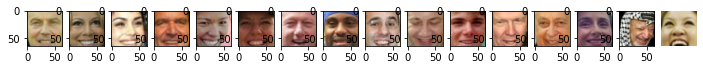

In [37]:
fig, axs = plt.subplots(1, 16, figsize=(12,12))
i=0
for k in smile:
    axs[i].imshow(np.rollaxis(X_train_t[k].detach().numpy(),0,3))
    i +=1
    plt.axis('off')
    
plt.show()

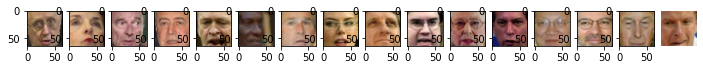

In [38]:
fig, axs = plt.subplots(1, 16, figsize=(12,12))
i=0
for k in not_smile:
    axs[i].imshow(np.rollaxis(X_train_t[k].detach().numpy(),0,3))
    i +=1
    plt.axis('off')
    
plt.show()

In [39]:
smile_people = autoencoder.encoder(X_train_t[smile].to(device))
not_smile_people = autoencoder.encoder(X_train_t[not_smile].to(device))

In [40]:
vector_smile= smile_people.mean(dim=0) - not_smile_people.mean(dim=0)

results = not_smile_people + vector_smile

In [41]:
not_smile_people_results = autoencoder.decoder(results).cpu()

In [ ]:
#Проверю результат

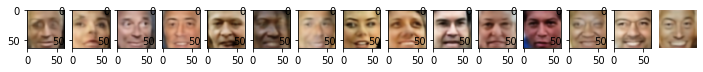

In [42]:
fig, axs = plt.subplots(1, 15, figsize=(12,12))

for k in range(15):
    axs[k].imshow(np.rollaxis(not_smile_people_results[k].detach().numpy(),0,3))
    plt.axis('off')
    
plt.show()

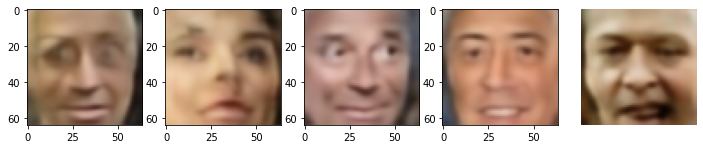

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(12,12))

for k in range(5):
    axs[k].imshow(np.rollaxis(not_smile_people_results[k].detach().numpy(),0,3))
    plt.axis('off')
    
plt.show()

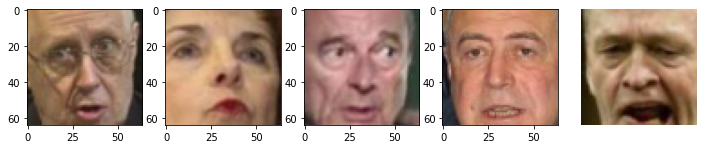

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(12,12))
i=0
for k in not_smile[0:5]:
    axs[i].imshow(np.rollaxis(X_train_t[k].detach().numpy(),0,3))
    i +=1
    plt.axis('off')
    
plt.show()

# Часть 2: Variational Autoencoder 

Обучением вариационных автоэнкодеров 

In [2]:
import torchvision.transforms as transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
dataloaders_mnist = {}
dataloaders_mnist['train'], dataloaders_mnist['val'] = train_loader, test_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение

Реализую VAE

In [4]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        #<определю архитектуры encoder и decoder

        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features = features, out_features =392),
            nn.ReLU(),
            nn.Linear(in_features = 392, out_features = 784)
        )
    def encode(self, x):
        #<реализую forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1,:]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплирую латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps*std)
            return sample
        else:

            return mu
    
    def decode(self, z):
        #<реализую forward проход декодера

        x=self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализую forward проход автоэнкодера

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
    
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [86]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        #<определю архитектуры encoder и decoder

        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features = features, out_features =392),
            nn.ReLU(),
            nn.Linear(in_features = 392, out_features = 784)
        )
    def encode(self, x):
        #<реализую forward проход энкодера

       
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1,:]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
 
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps*std)
            return sample
        else:

            return mu
    
    def decode(self, z):
        #<реализую forward проход декодера

        x=self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
    
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

In [8]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5*torch.sum(1+logsigma-mu.pow(2)-logsigma.exp())

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')#<binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu,logsigma) + log_likelihood(x,reconstruction)

И обучим модель:

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())#<Ваш любимый оптимизатор>

In [90]:
#Обучу модель
n_epochs = 1
train_losses = []
val_losses =[]
mu_history =[]
std_history = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch,_ in dataloaders_mnist['train']:
        optimizer.zero_grad()
        batch = batch.to(device)
        #print(autoencoder(batch))
        mu, logsigma, reconstruction = autoencoder(batch)
        mu_history.append(mu.mean())
        std_history.append(logsigma.mean())
        #print(reconstruction.shape)
        #print(batch.shape)
        reconstruction = reconstruction.view(-1,1, 28,28)
        loss = criterion(batch.to(device).float(), mu, logsigma,reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch,_ in dataloaders_mnist['val']:
            mu, logsigma, reconstruction = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1,1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma,reconstruction)
            train_losses_per_epoch.append(loss.item)
        val_losses.append(np.mean(val_losses_per_epoch))
                                          
        

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



In [33]:
CUDA_LAUNCH_BLOCKING=1

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

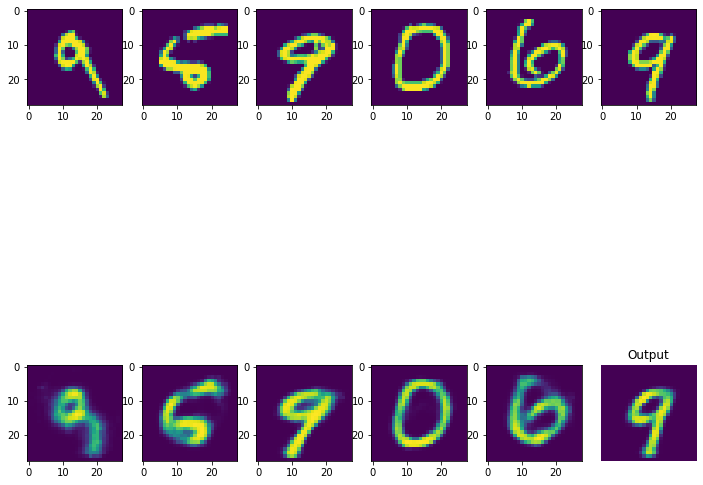

In [36]:

autoencoder.eval()
with torch.no_grad():
    for batch, _ in dataloaders_mnist['val']:
        mu, logsigma,Y_hat = autoencoder(batch.to(device))
        Y_hat= Y_hat.cpu()
        Y_hat = Y_hat.view(-1, 28, 28)
        
        fig, axs = plt.subplots(2, 6, figsize=(12,12))
        for k in range(7,13):
            axs[0][k-7].imshow(test_loader.dataset.data[k].numpy())
            plt.title('Real')
            plt.axis('off')

            axs[1][k-7].imshow(np.rollaxis(Y_hat[k].detach().cpu().numpy(), 1, 2))
            plt.title('Output')
            plt.axis('off')
        
        plt.show()
        break
        
    
    
    
    

Попробую подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [13]:
std = sum(std_history)/len(std_history)
mean = sum(mu_history)/len(mu_history)

In [14]:
z = torch.FloatTensor(
    [np.random.normal(0, 1, 16) for i in range(100)]).to(device)*std+mean

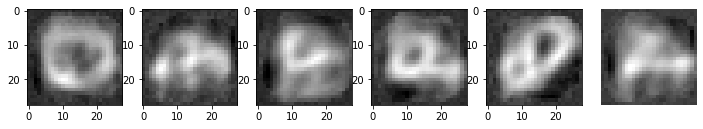

In [15]:


output = autoencoder.eval()
with torch.no_grad():
    Y_hat = autoencoder.decoder(z)
    Y_hat = Y_hat.view(-1, 28, 28)
fig, axs = plt.subplots(1, 6, figsize=(12,12))
for k in range(6):
    axs[k].imshow(np.rollaxis(Y_hat[k].detach().cpu().numpy(), 0, 2), cmap='gray')
    plt.axis('off')

plt.show()


## 2.3. Conditional VAE 


In [31]:
class CVAE(nn.Module):
    def __init__(self):

        super (CVAE, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features = 794, out_features = 392),
            nn.BatchNorm1d(392),
            nn.LeakyReLU(),
            
            nn.Linear(in_features = 392, out_features = 196),
            nn.BatchNorm1d(196),
            nn.LeakyReLU(),
            
            nn.Linear(in_features = 196, out_features = 98),
            nn.BatchNorm1d(98),
            nn.LeakyReLU(),
            
            
            nn.Linear(in_features=98, out_features=features*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features = 26, out_features =98),
            nn.BatchNorm1d(98),
            nn.LeakyReLU(),
            
            nn.Linear(in_features = 98, out_features = 196),
            nn.BatchNorm1d(196),
            nn.LeakyReLU(),
            
            nn.Linear(in_features = 196, out_features = 392),
            nn.BatchNorm1d(392),
            nn.LeakyReLU(),
            
            nn.Linear(in_features = 392, out_features = 784)
        )
        
        
    def encode(self, x, class_num):

        x = self.flatten(x).float()
        x = torch.cat([x, class_num], dim = 1)
        x = self.encoder(x).view(-1, 2, 16)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        
        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:

            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps*std)
            return sample
        else:

            return mu
    
    def decode(self, z, class_num):

        x = self.decoder(torch.cat([z,  class_num],dim=1))
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):

        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z,class_num)
        return mu, logsigma, reconstruction

In [32]:
#Обучу модель
criterion = loss_vae

vautoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(vautoencoder.parameters())

In [33]:
n_epochs = 10
train_losses = []
val_losses =[]
mu_history =[]
std_history = []

for epoch in tqdm(range(n_epochs)):
    vautoencoder.train()
    train_losses_per_epoch = []
    for batch,class_num in dataloaders_mnist['train']:
        optimizer.zero_grad()
        batch = batch.to(device)
        class_num = F.one_hot(class_num, 10)
        class_num  = class_num.to(device)
        #print(autoencoder(batch))
        mu, logsigma, reconstruction = vautoencoder(batch,class_num)
        mu_history.append(mu.mean())
        std_history.append(logsigma.mean())
        #print(reconstruction.shape)
        #print(batch.shape)
        reconstruction = reconstruction.view(-1,1, 28,28)
        loss = criterion(batch.to(device).float(), mu, logsigma,reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))
    

  0%|          | 0/10 [00:00<?, ?it/s]

### Sampling


Тут буду сэмплировать из CVAE

In [34]:
number = torch.IntTensor([0,1,2,3,4,5,6,7,8,9]).to(torch.int64)
number = F.one_hot(number, 10)


In [244]:

indexes_for_onehot = torch.IntTensor([0, 1,2,3,4,5,6,7,8,9]).to(torch.int64)

with torch.no_grad():
  onehot_matrix = F.one_hot(indexes_for_onehot, 10)

In [35]:
std = sum(std_history)/len(std_history)
mean = sum(mu_history)/len(mu_history)

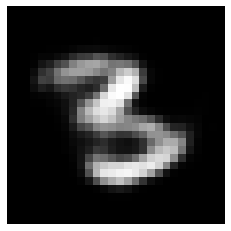

In [51]:

z = torch.FloatTensor(
    [np.random.normal(0, 1, 16) for i in range(10)]).to(device)
output = vautoencoder.eval()
with torch.no_grad():
    Y_hat = vautoencoder.decode(z,number.to(device))
    Y_hat = Y_hat.view(-1, 28, 28)
    Y_hat = Y_hat.permute(0,2,1)
    
    

plt.imshow(np.rollaxis(Y_hat[3].detach().cpu().numpy(), 0, 2), cmap='gray')
plt.axis('off')

plt.show()